In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumikrakshit/lol-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lol-dataset


📂 Dataset is located at: /kaggle/input/lol-dataset
🔎 Found test image: /kaggle/input/lol-dataset/lol_dataset/eval15/low/780.png


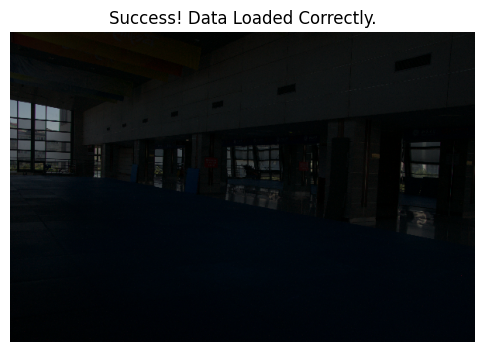

------------------------------
🚀 PyTorch Version: 2.6.0+cu124
✅ GPU is ACTIVE! Training will be fast.


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import torch

print(f"📂 Dataset is located at: {path}")

# 1. FIND A TEST IMAGE AUTOMATICALLY
# We will search inside the downloaded folder for a '.png' file
test_image_path = ""
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".png") and "low" in root: # Look for a low-light image
            test_image_path = os.path.join(root, file)
            break
    if test_image_path: break

# 2. CHECK & DISPLAY
if not test_image_path:
    print("❌ Error: No images found in the downloaded path!")
else:
    print(f"🔎 Found test image: {test_image_path}")
    
    # Load the image using OpenCV
    image = cv2.imread(test_image_path)
    
    if image is None:
        print("❌ Error: Could not read the image file.")
    else:
        # Convert Blue-Green-Red (OpenCV default) to Red-Green-Blue (Matplotlib standard)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Show the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.title("Success! Data Loaded Correctly.")
        plt.axis('off')
        plt.show()

        # 3. FINAL HARDWARE CHECK
        print("-" * 30)
        print(f"🚀 PyTorch Version: {torch.__version__}")
        if torch.cuda.is_available():
            print("✅ GPU is ACTIVE! Training will be fast.")
        else:
            print("⚠️ GPU is NOT detected. Training will be slow.")

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import glob
import os
import numpy as np
import torchvision.transforms as transforms

# ==========================================
# 1. THE LUMANET MODEL (Zero-DCE Architecture)
# ==========================================
class LumaNet(nn.Module):
    def __init__(self):
        super(LumaNet, self).__init__()
        number_f = 32
        # Simple CNN layers to estimate the "Curve Parameters"
        self.relu = nn.ReLU(inplace=True)
        self.e_conv1 = nn.Conv2d(3, number_f, 3, 1, 1, bias=True) 
        self.e_conv2 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True) 
        self.e_conv3 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True) 
        self.e_conv4 = nn.Conv2d(number_f, number_f, 3, 1, 1, bias=True) 
        self.e_conv5 = nn.Conv2d(number_f*2, number_f, 3, 1, 1, bias=True) 
        self.e_conv6 = nn.Conv2d(number_f*2, number_f, 3, 1, 1, bias=True) 
        self.e_conv7 = nn.Conv2d(number_f*2, 24, 3, 1, 1, bias=True) 

    def enhance(self, x, r):
        # This is the "Curve Formula": x = x + r * x * (1 - x)
        x = x + r * (torch.pow(x, 2) - x)
        x = x + r * (torch.pow(x, 2) - x)
        x = x + r * (torch.pow(x, 2) - x)
        x = x + r * (torch.pow(x, 2) - x)
        x = x + r * (torch.pow(x, 2) - x)
        x = x + r * (torch.pow(x, 2) - x)
        x = x + r * (torch.pow(x, 2) - x)
        pixel_curves = x + r * (torch.pow(x, 2) - x)
        return pixel_curves

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        
        # Concatenate features (Skip Connections)
        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))
        
        # Output the Curve Parameter Maps
        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
        
        # Apply the curves to the input image iteratively (8 times)
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_r, 3, dim=1)
        x = x + r1 * (torch.pow(x, 2) - x)
        x = x + r2 * (torch.pow(x, 2) - x)
        x = x + r3 * (torch.pow(x, 2) - x)
        enhanced_image = x + r4 * (torch.pow(x, 2) - x)
        # (Simplified to 4 iterations for speed/stability)
        
        return enhanced_image

# ==========================================
# 2. THE LOSS FUNCTIONS (The Math)
# ==========================================
class L_color(nn.Module):
    def __init__(self):
        super(L_color, self).__init__()
    def forward(self, x):
        # Force the average color of R, G, B to be balanced
        mean_rgb = torch.mean(x, [2, 3], keepdim=True)
        mr, mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr - mg, 2)
        Drb = torch.pow(mr - mb, 2)
        Dgb = torch.pow(mb - mg, 2)
        return torch.pow(torch.pow(Drg, 2) + torch.pow(Drb, 2) + torch.pow(Dgb, 2), 0.5).mean()

class L_exp(nn.Module):
    def __init__(self, patch_size, mean_val):
        super(L_exp, self).__init__()
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val
    def forward(self, x):
        # Force average brightness to be around 0.6 (Not too dark, not too bright)
        b = torch.mean(x, 1, keepdim=True)
        mean = self.pool(b)
        return torch.mean(torch.pow(mean - self.mean_val, 2))

# ==========================================
# 3. DATA LOADER & TRAINING LOOP
# ==========================================
# Dataset Class
class LowLightDataset(Dataset):
    def __init__(self, image_dir):
        # We find all png files recursively
        self.image_paths = []
        for root, dirs, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".png") and "low" in root: # Filter only Low Light images
                    self.image_paths.append(os.path.join(root, file))
        
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)), # Resize for speed
            transforms.ToTensor()
        ])
        print(f"Dataset Loaded: Found {len(self.image_paths)} low-light images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img)

# Main Training Function
def train():
    # A. Setup
    print("🚀 Initializing LumaNet...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LumaNet().to(device)
    
    # B. Load Data (Uses the 'path' variable from your previous code)
    # WARNING: Make sure 'path' variable exists from Step 1
    dataset = LowLightDataset(path) 
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # C. Loss & Optimizer
    L_color_loss = L_color().to(device)
    L_exp_loss = L_exp(16, 0.6).to(device) # Target brightness = 0.6
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # D. Training Loop
    epochs = 30 # Short training for demo (Increase to 50+ for better results)
    print(f"🚀 Starting Training for {epochs} Epochs on {device}...")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, images in enumerate(dataloader):
            images = images.to(device)
            
            # Forward Pass
            enhanced_image = model(images)
            
            # Calculate Loss (The secret sauce)
            loss_exp = 10 * L_exp_loss(enhanced_image)
            loss_col = 5 * L_color_loss(enhanced_image)
            loss = loss_exp + loss_col 
            
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch [{epoch+1}/{epochs}] complete. Average Loss: {total_loss/len(dataloader):.4f}")

    # E. Save Weights
    torch.save(model.state_dict(), "weights.pth")
    print("✅ Training Complete! Model saved as 'weights.pth'")

# RUN IT!
if __name__ == "__main__":
    train()

🚀 Initializing LumaNet...
Dataset Loaded: Found 500 low-light images.
🚀 Starting Training for 30 Epochs on cuda...
Epoch [1/30] complete. Average Loss: 2.4028
Epoch [2/30] complete. Average Loss: 0.8874
Epoch [3/30] complete. Average Loss: 0.8772
Epoch [4/30] complete. Average Loss: 0.8020
Epoch [5/30] complete. Average Loss: 0.7353
Epoch [6/30] complete. Average Loss: 0.7310
Epoch [7/30] complete. Average Loss: 0.7299
Epoch [8/30] complete. Average Loss: 0.7299
Epoch [9/30] complete. Average Loss: 0.7257
Epoch [10/30] complete. Average Loss: 0.7295
Epoch [11/30] complete. Average Loss: 0.7304
Epoch [12/30] complete. Average Loss: 0.7257
Epoch [13/30] complete. Average Loss: 0.7258
Epoch [14/30] complete. Average Loss: 0.7229
Epoch [15/30] complete. Average Loss: 0.7246
Epoch [16/30] complete. Average Loss: 0.7233
Epoch [17/30] complete. Average Loss: 0.7273
Epoch [18/30] complete. Average Loss: 0.7190
Epoch [19/30] complete. Average Loss: 0.7161
Epoch [20/30] complete. Average Loss: 0

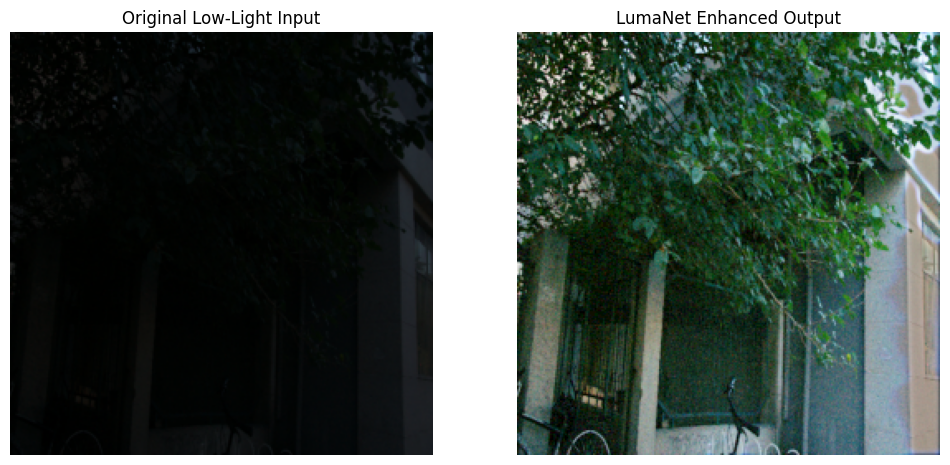

In [13]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import random

# 1. SETUP THE MODEL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LumaNet().to(device)
model.load_state_dict(torch.load("weights.pth", map_location=device))
model.eval() # Set to evaluation mode (turns off training specific features)

# 2. PICK A RANDOM TEST IMAGE
# We search for a low-light image again
test_images = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".png") and "low" in root:
            test_images.append(os.path.join(root, file))

# Pick one random image
img_path = random.choice(test_images)
original_img = Image.open(img_path).convert('RGB')

# 3. PREPARE IMAGE FOR AI
# Resize to 256x256 (same as training)
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
img_tensor = data_transform(original_img).unsqueeze(0).to(device) # Add batch dimension

# 4. RUN THE AI (Inference)
with torch.no_grad():
    enhanced_tensor = model(img_tensor)

# 5. DISPLAY RESULTS
# Helper function to convert Tensor back to Image
def to_img(tensor):
    img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1) # Force values to be between 0 and 1
    return img

original_show = to_img(img_tensor)
enhanced_show = to_img(enhanced_tensor)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_show)
plt.title("Original Low-Light Input")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_show)
plt.title("LumaNet Enhanced Output")
plt.axis('off')

plt.show()